# Team 3 Final Project Model
### Andy Stevens, Andrew Pan, Luke Vanni, Jameson Orvis

In [0]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn import preprocessing
from sklearn.manifold import TSNE
import datetime

1. Remove data points with non numeric fields
2. Standardize Data (what method, normalized to mean and stDev)?
3. Covariance Matrix for each field vs. Impurity Rate
4. Run Linear Regression on those related data fields
5. Make a scatter plot (Classification) to characterize the fail vs. pass



## Loading the Data

,Date,x1:Primary Column Reflux Flow,x2:Primary Column Tails Flow,x3:Input to Primary Column Bed 3 Flow,x4:Input to Primary Column Bed 2 Flow,x5:Primary Column Feed Flow from Feed Column,x6:Primary Column Make Flow,x7:Primary Column Base Level,x8:Primary Column Reflux Drum Pressure,x9:Primary Column Condenser Reflux Drum Level,x10:Primary Column Bed1 DP,x11:Primary Column Bed2 DP,x12:Primary Column Bed3 DP,x13:Primary Column Bed4 DP,x14:Primary Column Base Pressure,x15:Primary Column Head Pressure,x16:Primary Column Tails Temperature,x17:Primary Column Tails Temperature 1,x18:Primary Column Bed 4 Temperature,x19:Primary Column Bed 3 Temperature,x20:Primary Column Bed 2 Temperature,x21:Primary Column Bed 1 Temperature,x22: Secondary Column Base Concentration,x23: Flow from Input to Secondary Column,x24: Secondary Column Tails Flow,x25: Secondary Column Tray DP,x26: Secondary Column Head Pressure,x27: Secondary Column Base Pressure,x28: Secondary Column Base Temperature,x29: Secondary Column Tray 3 Temperature,x30: Secondary Column Bed 1 Temperature,x31: Secondary Column Bed 2 Temperature,x32: Secondary Column Tray 2 Temperature,x33: Secondary Column Tray 1 Temperature,x34: Secondary Column Tails Temperature,x35: Secondary Column Tails Concentration,x36: Feed Column Recycle Flow,x37: Feed Column Tails Flow to Primary Column,x38: Feed Column Calculated DP,x39: Feed Column Steam Flow,x40: Feed Column Tails Flow,y:Impurity
0,1.448928e+09,327.813,45.7920,2095.06,2156.01,98.5005,95.4674,54.3476,41.0121,52.2353,6.86666,10.6779,8.12894,8.56020,42.2393,40.9597,52.6953,23.4202,49.4764,49.5943,50.8120,51.3843,0.014411,1257.24,8.75854,6.35619,42.6542,43.7373,142.680,66.3713,59.4682,55.8463,84.7172,124.330,141.965,0.013060,62.8707,45.0085,66.6604,8.68813,99.9614,1.77833
1,1.448932e+09,322.970,46.1643,2101.00,2182.90,98.0014,94.9673,54.2247,41.0076,52.5378,6.70838,10.5690,7.83157,8.37297,42.2257,41.0177,52.5954,22.9557,49.4889,49.5918,50.8096,51.3626,0.015383,1417.43,8.81707,6.12842,42.7509,43.7412,141.679,66.1499,59.1892,55.8329,83.4434,110.837,141.352,0.013666,62.8651,45.0085,66.5496,8.70683,99.8637,1.76964
2,1.448935e+09,319.674,45.9927,2102.96,2151.39,98.8229,96.0785,54.6130,41.0451,52.0159,6.75303,10.6124,7.84894,8.40938,42.2402,41.0575,52.8304,22.8949,49.4914,49.5918,50.8190,51.3791,0.014897,1538.70,8.84735,6.12386,42.7568,43.7108,142.098,66.1450,59.2361,55.8378,84.1269,113.329,141.587,0.013498,62.8656,45.0085,66.0599,8.69269,100.2490,1.76095
3,1.448939e+09,327.223,46.0960,2101.37,2172.14,98.7733,96.1223,54.9153,41.0405,52.9477,6.93766,10.9209,8.12147,8.69578,42.2859,41.0814,52.9296,22.8342,49.5174,49.6108,50.8215,51.3982,0.014411,1459.21,8.89552,6.17319,42.7485,43.7946,142.683,66.7973,59.6150,55.8707,108.7830,127.831,142.125,0.013104,62.8669,45.0085,67.9697,8.70482,100.3200,1.75226
4,1.448942e+09,331.177,45.8493,2114.06,2157.77,99.3231,94.7521,54.0925,40.9934,53.0507,6.87966,10.9171,8.12338,8.69578,42.2178,41.0436,52.8591,22.7126,49.4725,49.5724,50.7995,51.3656,0.014411,1529.97,8.82490,6.21475,42.7677,43.7728,142.678,66.5091,59.4871,55.8389,88.9764,124.675,141.955,0.013085,62.8673,45.0085,67.6454,8.70077,100.6590,1.74357


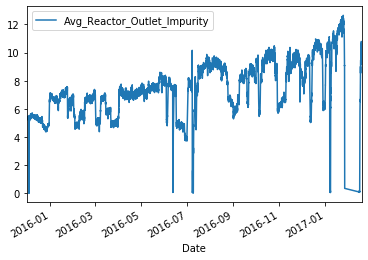

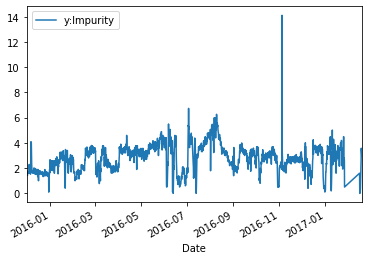

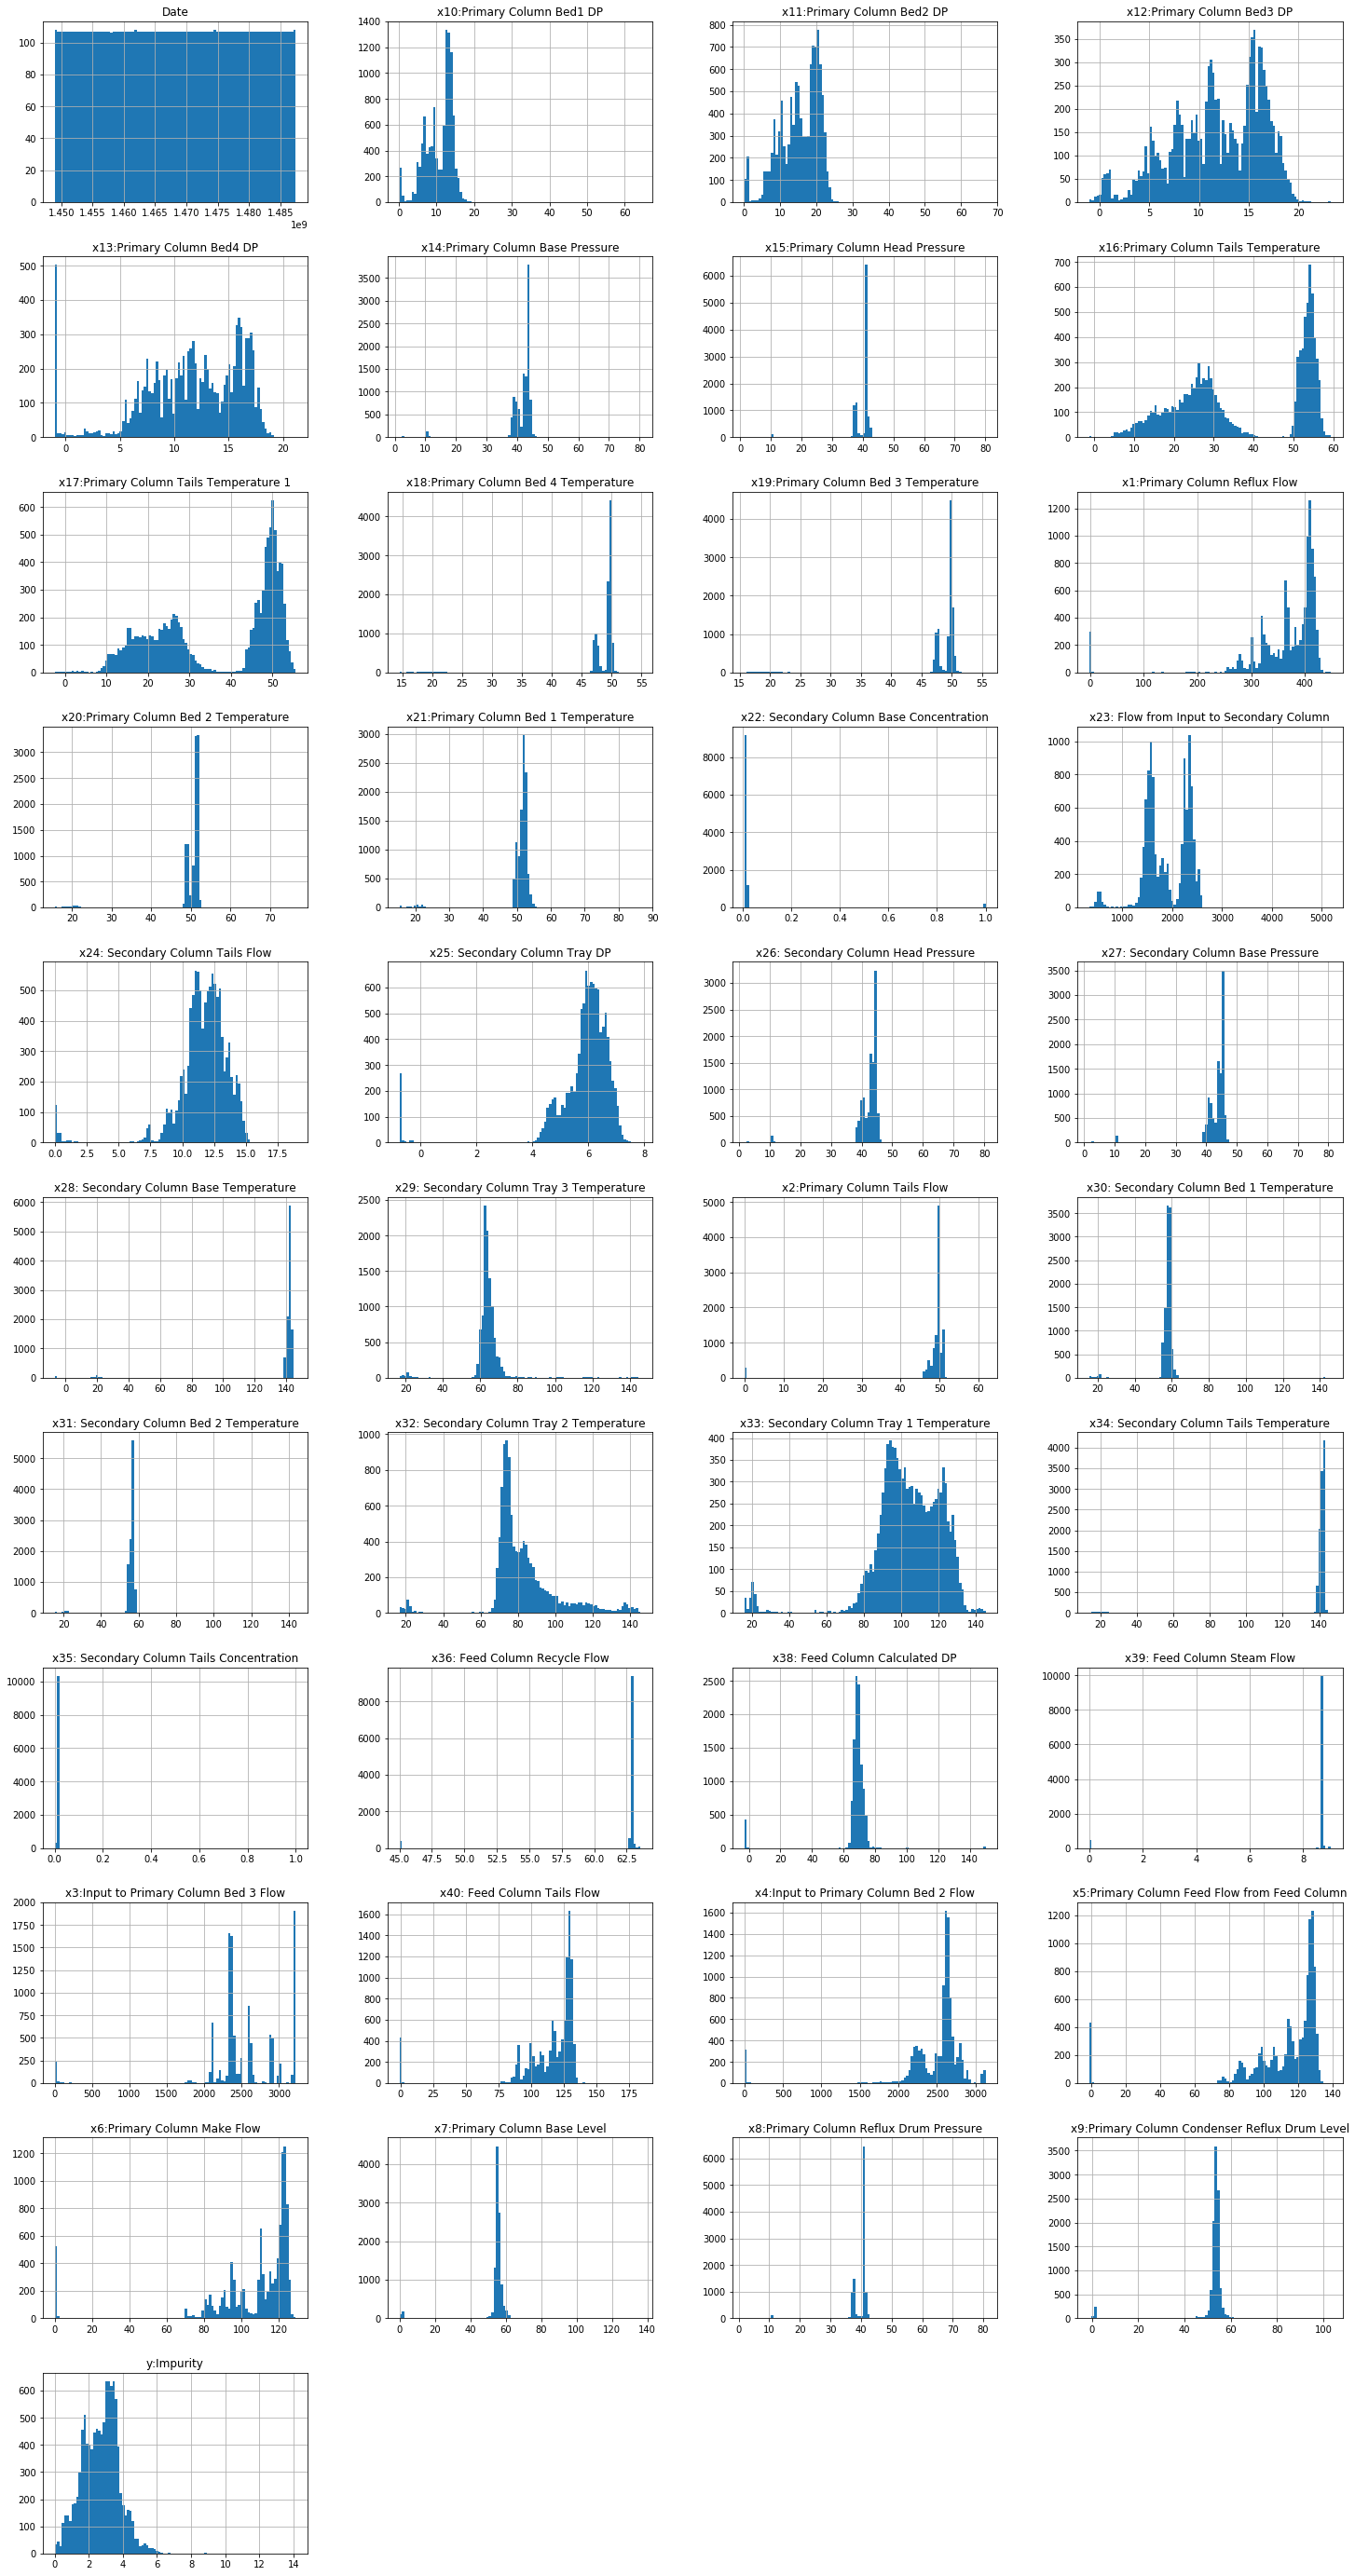

In [0]:
url_train = 'https://raw.githubusercontent.com/astevens37/COE3801Final/master/impurity_dataset-training.xlsx'
url_validate = 'https://raw.githubusercontent.com/astevens37/COE3801Final/master/impurity_dataset-validation.xlsx'
df_train = pd.read_excel(url_train)
df_validate = pd.read_excel(url_validate)

df_train.plot(x='Date', y='Avg_Reactor_Outlet_Impurity')
df_train.plot(x='Date', y='y:Impurity')

# Remove unneeded columns because they aren't features for us to build our model off of
df_train = df_train.drop(["Avg_Delta_Composition Primary Column","Primary Column Reflux/Feed Ratio","Primary Column Make/Reflux Ratio","Avg_Reactor_Outlet_Impurity"], axis=1)
df_validate = df_validate.drop(["Avg_Delta_Composition Primary Column","Primary Column Reflux/Feed Ratio","Primary Column Make/Reflux Ratio","Avg_Reactor_Outlet_Impurity"], axis=1)

#df_train = df_train.set_index('Date')
#df_validate = df_validate.set_index('Date')

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_validate['Date'] = pd.to_datetime(df_validate['Date'])

dates_train = df_train['Date'].tolist()
for i in range(len(dates_train)):
  dates_train[i] = pd.to_datetime(dates_train[i]).timestamp()
df_train['Date'] = dates_train

dates_validate = df_validate['Date'].tolist()
for i in range(len(dates_validate)):
  dates_validate[i] = pd.to_datetime(dates_validate[i]).timestamp()
df_validate['Date'] = dates_validate

df_train.hist(bins=100, figsize=(25,50), layout=(11,4))

df_train.head(5)

## Removing Rows Containing a Non-Numeric Value

In [0]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

In [0]:
df_train.isna().sum()

Date                                              0
x1:Primary Column Reflux Flow                    30
x2:Primary Column Tails Flow                     22
x3:Input to Primary Column Bed 3 Flow            21
x4:Input to Primary Column Bed 2 Flow            21
x5:Primary Column Feed Flow from Feed Column     21
x6:Primary Column Make Flow                      21
x7:Primary Column Base Level                     21
x8:Primary Column Reflux Drum Pressure           21
x9:Primary Column Condenser Reflux Drum Level    19
x10:Primary Column Bed1 DP                       19
x11:Primary Column Bed2 DP                       19
x12:Primary Column Bed3 DP                       19
x13:Primary Column Bed4 DP                       20
x14:Primary Column Base Pressure                 19
x15:Primary Column Head Pressure                 21
x16:Primary Column Tails Temperature             19
x17:Primary Column Tails Temperature 1           19
x18:Primary Column Bed 4 Temperature             19
x19:Primary 

In [0]:
numeric_map_train = df_train[df_train.columns[:]].applymap(is_real_and_finite)
real_rows_train = numeric_map_train.all(axis=1).copy().values #True if all values in a row are real numbers
X_train = np.array(df_train.loc[real_rows_train,:], dtype='float')
print(np.shape(df_train))
print(np.shape(X_train))
print('Number of rows removed from training: {}'.format(np.shape(df_train)[0]-np.shape(X_train)[0]))

numeric_map_val = df_validate[df_validate.columns[:]].applymap(is_real_and_finite)
real_rows_val = numeric_map_val.all(axis=1).copy().values #True if all values in a row are real numbers
X_validate = np.array(df_validate.loc[real_rows_val,:], dtype='float')
print(np.shape(df_validate))
print(np.shape(X_validate))
print('Number of rows removed from validation: {}'.format(np.shape(df_validate)[0]-np.shape(X_validate)[0]))

(10703, 42)
(10666, 42)
Number of rows removed from training: 37
(5959, 42)
(5735, 42)
Number of rows removed from validation: 224


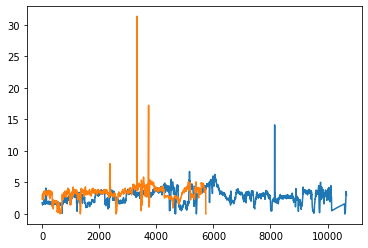

In [0]:
plt.plot(range(len(X_train)), X_train[:,41])
plt.plot(range(len(X_validate)), X_validate[:,41])

## Standardizing The Data

In [0]:
from sklearn.model_selection import train_test_split

X = np.concatenate((X_train, X_validate), axis=0)
X_train, X_test = train_test_split(X, test_size=0.33, random_state=42, shuffle=False)

scaler_train = preprocessing.StandardScaler().fit(X_train)

X_train = scaler_train.transform(X_train)
X_validate = scaler_train.transform(X_validate) #Standardize validation set based on training set

# Labeling Failure Points

In [0]:
##Failure Points in Training
failure=[]
impurity_train = X_train[:,41]
impurity_val = X_validate[:,41]


In [0]:
acceptable_max = np.mean(impurity_train) + (np.std(impurity_train)/2)
#arbitrarily chosen impurity level for the failure threshold
#importantly, this is the same threshold for both the training and validation data set

for i in range(len(X_train)):
  if impurity_train[i] >= acceptable_max:
    tf=1
  else:
    tf=0
  failure.append(tf)

##Failure Points in Validation
failure_val=[]
for i in range(len(X_validate)):
  if impurity_val[i] >= acceptable_max:
    tf=1
  else:
    tf=0
  failure_val.append(tf)
print(failure)
print(failure_val)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [0]:
#Want to remove impurity level from feature matrix

X_train = X_train[:,:41]
X_validate = X_validate[:,:41]

## Covariance Matrix

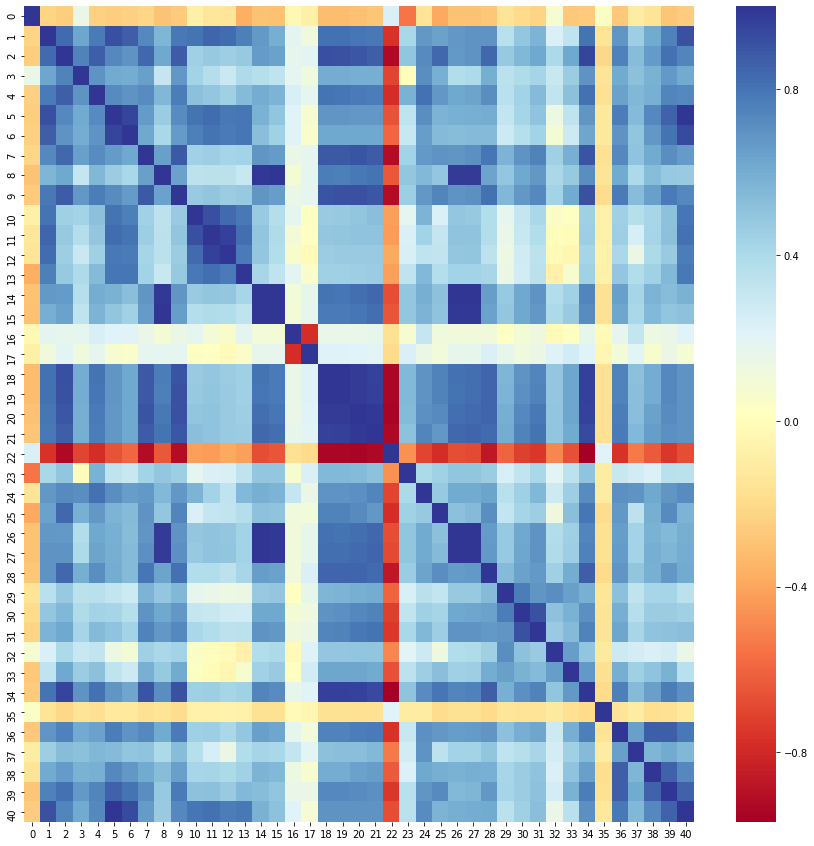

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(pd.DataFrame(X_train).cov(), ax=ax, cmap='RdYlBu')

In [0]:
pd.DataFrame(X_train).cov()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
0,1.000091,-0.222081,-0.247404,0.150761,-0.244023,-0.252540,-0.242511,-0.215146,-0.298029,-0.267844,-0.083513,-0.136832,-0.148524,-0.371085,-0.295756,-0.298870,-0.028896,-0.083173,-0.317511,-0.315931,-0.302786,-0.288100,0.233217,-0.545468,-0.153040,-0.385856,-0.292991,-0.297387,-0.277883,-0.154043,-0.194999,-0.222413,0.071122,-0.269872,-0.261149,0.042458,-0.271220,-0.099672,-0.155805,-0.288672,-0.255246
1,-0.222081,1.000091,0.834793,0.629082,0.782060,0.915655,0.870906,0.731258,0.566611,0.786563,0.801423,0.849579,0.827631,0.762586,0.674898,0.599216,0.185973,0.108856,0.810129,0.809898,0.799380,0.791067,-0.762782,0.414864,0.682626,0.644440,0.684742,0.695133,0.695521,0.361823,0.485429,0.573043,0.237935,0.337522,0.802573,-0.154817,0.686748,0.460416,0.614462,0.760662,0.909937
2,-0.247404,0.834793,1.000091,0.747762,0.872014,0.735410,0.693880,0.844232,0.623297,0.881734,0.452514,0.479328,0.457817,0.484867,0.665985,0.640100,0.173167,0.198186,0.918349,0.914557,0.898072,0.872444,-0.923304,0.498483,0.730934,0.846319,0.675915,0.694460,0.840344,0.479548,0.560164,0.620235,0.404068,0.618931,0.952257,-0.212720,0.754501,0.533077,0.666174,0.812118,0.740902
3,0.150761,0.629082,0.747762,1.000091,0.699666,0.613002,0.601447,0.652236,0.315743,0.680756,0.435125,0.373268,0.298073,0.399096,0.366360,0.334743,0.182736,0.118075,0.605143,0.604758,0.599898,0.599799,-0.702804,0.002991,0.711833,0.592384,0.381074,0.395372,0.595115,0.348603,0.385466,0.429946,0.303559,0.468533,0.696275,-0.156641,0.614888,0.519274,0.577578,0.674927,0.613066
4,-0.244023,0.782060,0.872014,0.699666,1.000091,0.726150,0.695453,0.720024,0.556363,0.774305,0.522387,0.491722,0.450099,0.540236,0.607852,0.574674,0.243706,0.175761,0.801566,0.796919,0.782901,0.775520,-0.779255,0.578339,0.812919,0.680821,0.620247,0.632134,0.711833,0.357329,0.434772,0.541247,0.326914,0.518464,0.814892,-0.173369,0.640399,0.558850,0.591434,0.745139,0.732697
5,-0.252540,0.915655,0.735410,0.613002,0.726150,1.000091,0.950392,0.662089,0.463789,0.721877,0.806390,0.828354,0.788881,0.798251,0.577517,0.498464,0.210067,0.071514,0.685378,0.686884,0.683368,0.684172,-0.657070,0.334181,0.711843,0.571297,0.589314,0.597239,0.600845,0.323392,0.424278,0.502976,0.137016,0.337436,0.692172,-0.128419,0.773604,0.544372,0.731142,0.857245,0.993715
6,-0.242511,0.870906,0.693880,0.601447,0.695453,0.950392,1.000091,0.616375,0.411548,0.665455,0.762015,0.804582,0.779828,0.797614,0.525095,0.446117,0.204196,0.052511,0.618609,0.621076,0.619134,0.617943,-0.596730,0.307740,0.656779,0.546432,0.537445,0.545792,0.544856,0.279632,0.362430,0.432651,0.086907,0.284077,0.629852,-0.122928,0.699963,0.497187,0.683807,0.803587,0.936578
7,-0.215146,0.731258,0.844232,0.652236,0.720024,0.662089,0.616375,1.000091,0.653248,0.891275,0.439862,0.454981,0.424801,0.438988,0.687481,0.666726,0.157479,0.176971,0.885045,0.888714,0.902855,0.878601,-0.911065,0.432478,0.671572,0.698947,0.690702,0.702966,0.799887,0.572245,0.697839,0.747268,0.447094,0.591320,0.905512,-0.169553,0.736544,0.508065,0.611930,0.713301,0.668735
8,-0.298029,0.566611,0.623297,0.315743,0.556363,0.463789,0.411548,0.653248,1.000091,0.643870,0.341724,0.352366,0.347337,0.300993,0.987346,0.999096,0.090222,0.177886,0.772838,0.768130,0.785441,0.807631,-0.637880,0.487304,0.552154,0.489879,0.984663,0.983618,0.635437,0.485584,0.616040,0.678015,0.412607,0.478027,0.709057,-0.160343,0.610545,0.403293,0.535941,0.478745,0.474561
9,-0.267844,0.786563,0.881734,0.680756,0.774305,0.721877,0.665455,0.891275,0.643870,1.000091,0.475100,0.494470,0.462628,0.477604,0.685160,0.659262,0.152839,0.184166,0.902220,0.909808,0.914802,0.893245,-0.910626,0.459415,0.681206,0.745940,0.693330,0.707387,0.814654,0.556971,0.680453,0.733375,0.434686,0.614708,0.913444,-0.190684,0.777309,0.533285,0.654153,0.783885,0.733550


In [0]:
nparray=np.asarray(pd.DataFrame(X_train).cov())
print(nparray)

[[ 1.00009102 -0.22208087 -0.24740439 ... -0.15580463 -0.28867247
  -0.25524617]
 [-0.22208087  1.00009102  0.83479325 ...  0.61446157  0.76066207
   0.90993673]
 [-0.24740439  0.83479325  1.00009102 ...  0.66617397  0.81211786
   0.74090193]
 ...
 [-0.15580463  0.61446157  0.66617397 ...  1.00009102  0.85857495
   0.73249801]
 [-0.28867247  0.76066207  0.81211786 ...  0.85857495  1.00009102
   0.86005062]
 [-0.25524617  0.90993673  0.74090193 ...  0.73249801  0.86005062
   1.00009102]]


In [0]:
##Find Areas of High Covariance
highpos=np.where(nparray>=0.9)
print(highpos)
print(len(highpos[0]))
##Find Areas of Low Covariance
lowpos=np.where(nparray<=-0.9)
print(lowpos)
print(len(lowpos[0]))

(array([ 0,  1,  1,  1,  2,  2,  2,  2,  3,  4,  5,  5,  5,  5,  6,  6,  6,
        7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 11, 11,
       11, 12, 12, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 17, 18,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 21, 21, 21, 21, 21, 22, 23, 24, 25, 26, 26, 26, 26, 26,
       27, 27, 27, 27, 27, 28, 29, 30, 30, 31, 31, 32, 33, 34, 34, 34, 34,
       34, 34, 34, 34, 35, 36, 37, 38, 39, 40, 40, 40, 40]), array([ 0,  1,  5, 40,  2, 18, 19, 34,  3,  4,  1,  5,  6, 40,  5,  6, 40,
        7, 20, 34,  8, 14, 15, 26, 27,  9, 18, 19, 20, 34, 10, 11, 10, 11,
       12, 11, 12, 13,  8, 14, 15, 26, 27,  8, 14, 15, 26, 27, 16, 17,  2,
        9, 18, 19, 20, 21, 34,  2,  9, 18, 19, 20, 21, 34,  7,  9, 18, 19,
       20, 21, 34, 18, 19, 20, 21, 34, 22, 23, 24, 25,  8, 14, 15, 26, 27,
        8, 14, 15, 26, 27, 28, 29, 30, 31, 30, 31, 32, 33,  2,  7,  9, 18,
       19, 20, 21, 34, 35, 36, 37, 38,

## Regression

In [0]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(X_train, impurity_train)
print('Testing Score: {}'.format(model.score(X_train, impurity_train)))
print('Validation Score: {}'.format(model.score(X_validate, impurity_val)))

Testing Score: 0.7154578160222747
Validation Score: -0.6181000115493411


In [0]:
#from sklearn.kernel_ridge import KernelRidge

model = KernelRidge(kernel='rbf',alpha=0.01,gamma=0.1)
model.fit(X_train, impurity_train)
print('Testing Score: {}'.format(model.score(X_train, impurity_train)))
print('Validation Score: {}'.format(model.score(X_validate, impurity_val)))

NameError: ignored

# Classification

In [0]:
#Logistic Regression

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions_lr = model.predict(X_validate)
testing_class_report = classification_report(failure_val, predictions_lr, output_dict = True)
print(testing_class_report)

Testing Score: 0.8521113942482709
Validation Score: 0.8
{'0': {'precision': 0.8359335681932561, 'recall': 0.669218372280419, 'f1-score': 0.7433430297605729, 'support': 2482}, '1': {'precision': 0.7809498399146211, 'recall': 0.8997848140178297, 'f1-score': 0.8361662619625767, 'support': 3253}, 'accuracy': 0.8, 'macro avg': {'precision': 0.8084417040539387, 'recall': 0.7845015931491244, 'f1-score': 0.7897546458615747, 'support': 5735}, 'weighted avg': {'precision': 0.8047457620746162, 'recall': 0.8, 'f1-score': 0.7959941150880565, 'support': 5735}}


In [0]:
#Support vector machine

from sklearn import svm

model = svm.SVC(gamma='auto', C=10)
model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions_svm = model.predict(X_validate)
print(predictions_svm.size)

testing_class_report = classification_report(failure_val, predictions_svm, output_dict = True)
print(testing_class_report)

Testing Score: 0.9019839825263924
Validation Score: 0.55640802092415
5735
{'0': {'precision': 0.4927772600186393, 'recall': 0.8521353746978243, 'f1-score': 0.6244464127546501, 'support': 2482}, '1': {'precision': 0.7456687456687456, 'recall': 0.3307715954503535, 'f1-score': 0.4582623509369677, 'support': 3253}, 'accuracy': 0.55640802092415, 'macro avg': {'precision': 0.6192230028436925, 'recall': 0.5914534850740889, 'f1-score': 0.5413543818458089, 'support': 5735}, 'weighted avg': {'precision': 0.6362220730648112, 'recall': 0.55640802092415, 'f1-score': 0.5301836833574538, 'support': 5735}}


In [0]:
#Random forest classifier without hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions = model.predict(X_validate)
print(predictions.size)

testing_class_report = classification_report(failure_val, predictions, output_dict = True)
print(testing_class_report)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Testing Score: 0.9954495813614852
Validation Score: 0.708456843940715
5735
{'0': {'precision': 0.6254646840148699, 'recall': 0.8134568896051572, 'f1-score': 0.7071803852889667, 'support': 2482}, '1': {'precision': 0.8153171120861588, 'recall': 0.6283430679372887, 'f1-score': 0.7097222222222221, 'support': 3253}, 'accuracy': 0.708456843940715, 'macro avg': {'precision': 0.7203908980505143, 'recall': 0.7208999787712229, 'f1-score': 0.7084513037555944, 'support': 5735}, 'weighted avg': {'precision': 0.733152556467512, 'recall': 0.708456843940715, 'f1-score': 0.7086221630647086, 'support': 5735}}


In [0]:
#Hyperparameter tuning for random forest. Adapted from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

#Leaving this line commented by default. This literally took me an hour to run. The hyperparameters from this are used in the code block below

#rf_random.fit(X_train, failure)

In [0]:
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=1,max_features='auto',max_depth=50,bootstrap=False)
#model.fit(X_train, failure)

print('Testing Score: {}'.format(model.score(X_train, failure)))
print('Validation Score: {}'.format(model.score(X_validate, failure_val)))

predictions = model.predict(X_validate)
print(predictions.size)

testing_class_report = classification_report(failure_val, predictions, output_dict = True)
print(testing_class_report)

Testing Score: 0.9954495813614852
Validation Score: 0.708456843940715
5735
{'0': {'precision': 0.6254646840148699, 'recall': 0.8134568896051572, 'f1-score': 0.7071803852889667, 'support': 2482}, '1': {'precision': 0.8153171120861588, 'recall': 0.6283430679372887, 'f1-score': 0.7097222222222221, 'support': 3253}, 'accuracy': 0.708456843940715, 'macro avg': {'precision': 0.7203908980505143, 'recall': 0.7208999787712229, 'f1-score': 0.7084513037555944, 'support': 5735}, 'weighted avg': {'precision': 0.733152556467512, 'recall': 0.708456843940715, 'f1-score': 0.7086221630647086, 'support': 5735}}


# Cluster Classification


In [0]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

scores = []
#for i in range(2,11):
#    n_clusters = i
#    model = KMeans(n_clusters=n_clusters)
#    model.fit(X_train)
#    y_predict = model.predict(X_train)
#    print(y_predict)
#    scores.append(silhouette_score(X_train, y_predict))

#fig, ax = plt.subplots()
#ax.plot(range(2,11), scores)
#ax.set_xlabel('n_clusters')
#ax.set_ylabel('mean silhouette score')

Text(0.5, 1.0, 'Actual training set')

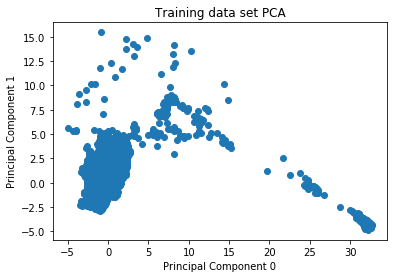

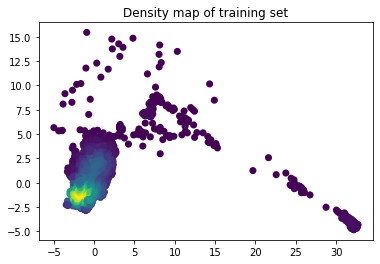

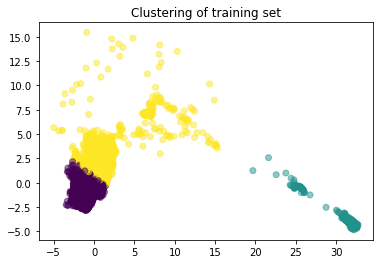

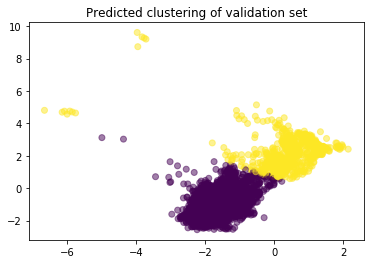

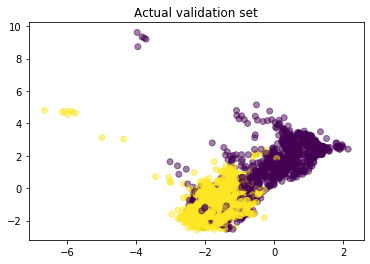

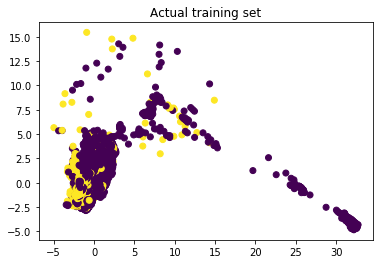

In [0]:
pca = PCA(n_components = 2)

from scipy.stats import gaussian_kde
n_comp = 3

X_train_pca = pca.fit_transform(X_train)
xy = np.vstack([X_train_pca[:,0],X_train_pca[:,1]])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1])
ax.set_title('Training data set PCA')
ax.set_xlabel('Principal Component 0')
ax.set_ylabel('Principal Component 1')

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=z, s=50, edgecolor='')
ax.set_title('Density map of training set')

fig, ax = plt.subplots()
model = KMeans(n_clusters=n_comp)
model.fit(X_train_pca)
y_predict = model.predict(X_train_pca)
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_predict, cmap='viridis', alpha=0.5)
ax.set_title('Clustering of training set')

fig, ax = plt.subplots()
X_validate_pca = pca.transform(X_validate)
y_predict = model.predict(X_validate_pca)
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=y_predict, cmap='viridis', alpha=0.5)
ax.set_title('Predicted clustering of validation set')

fig, ax = plt.subplots()
y_predict = model.predict(X_validate_pca)
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=failure_val, cmap='viridis', alpha=0.5)
ax.set_title('Actual validation set')

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=failure)
ax.set_title('Actual training set')

10988
Testing Score: 0.9933454325468845
1
Testing Score: 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Testing Score: 0.8305129913391073


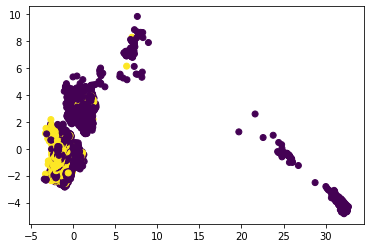

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_samples
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

failure = np.array(failure)
cluster_model = KMeans(n_clusters=n_comp)
cluster_model.fit(X_train)
y_predict = cluster_model.predict(X_train)
scores = silhouette_samples(X_train, y_predict)

print(len(scores))

outlier_cutoff = 0.1
mask = (np.array(scores) > outlier_cutoff)
X_train_reduced = X_train[mask,:]
failure_reduced = failure[mask]

fig, ax = plt.subplots()
ax.scatter(X_train_pca[mask,0], X_train_pca[mask,1], c=failure[mask])

y_predict = cluster_model.predict(X_train_reduced)
#y_predict = cluster_model.predict(X_train)

models = []

for i in range(n_comp):
    
    mask = (y_predict == i)
    data = X_train_reduced[mask,:]
    masked_failure = failure_reduced[mask]

    if np.all(masked_failure == 0): 
        
        #this is a very dumb workaround to the logistic regression model throwing an error
        #if every data point is assigned as a failure
        
        class dumb_model:           
            def _init_():
                print('yeet')
            
            def fit(X_train, y):
                print('lol')
                
            def predict(self, X):
                return np.zeros(data.shape[0])
            
            def score(self, X, y):
                return 1.0
        
        print(i)
        model = dumb_model()
    else:
        model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
        model.fit(data, masked_failure)
    print('Testing Score: {}'.format(model.score(data, masked_failure)))
    models.append(model)

0
1181
1
0
2
4554
{'0': {'precision': 0.8389199255121043, 'recall': 0.726027397260274, 'f1-score': 0.778401727861771, 'support': 2482}, '1': {'precision': 0.8104265402843602, 'recall': 0.8936366430986782, 'f1-score': 0.85, 'support': 3253}, 'accuracy': 0.8210985178727114, 'macro avg': {'precision': 0.8246732328982322, 'recall': 0.8098320201794761, 'f1-score': 0.8142008639308855, 'support': 5735}, 'weighted avg': {'precision': 0.822757940831049, 'recall': 0.8210985178727114, 'f1-score': 0.819013616138259, 'support': 5735}}
{'0': {'precision': 0.8359335681932561, 'recall': 0.669218372280419, 'f1-score': 0.7433430297605729, 'support': 2482}, '1': {'precision': 0.7809498399146211, 'recall': 0.8997848140178297, 'f1-score': 0.8361662619625767, 'support': 3253}, 'accuracy': 0.8, 'macro avg': {'precision': 0.8084417040539387, 'recall': 0.7845015931491244, 'f1-score': 0.7897546458615747, 'support': 5735}, 'weighted avg': {'precision': 0.8047457620746162, 'recall': 0.8, 'f1-score': 0.79599411508

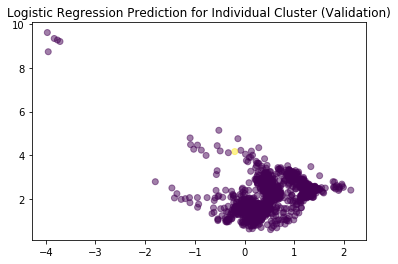

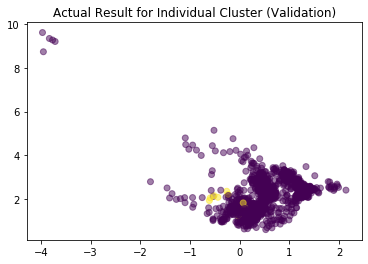

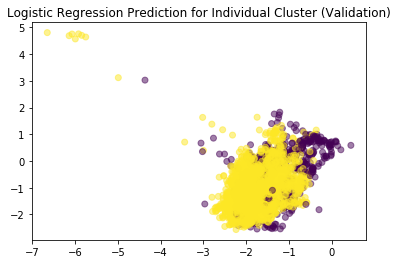

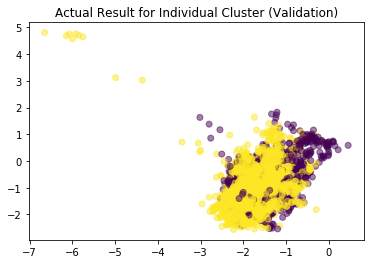

In [0]:
predicted_clusters = cluster_model.predict(X_validate)

y_predict = np.zeros(X_validate.shape[0])
failure_val = np.array(failure_val)
for i in range(n_comp):
    print(i)
    mask = (predicted_clusters == i)
    print(len(y_predict[mask]))
    data = X_validate[mask,:]
    if (data.shape[0] == 0):
        continue
    cluster_pred = models[i].predict(data)
    fig, ax = plt.subplots()
    ax.scatter(X_validate_pca[mask,0], X_validate_pca[mask,1], c=cluster_pred, cmap='viridis', alpha=0.5)
    ax.set_title('Logistic Regression Prediction for Individual Cluster (Validation)')
    
    fig, ax = plt.subplots()
    ax.scatter(X_validate_pca[mask,0], X_validate_pca[mask,1], c=failure_val[mask], cmap='viridis', alpha=0.5)
    ax.set_title('Actual Result for Individual Cluster (Validation)')
    y_predict[mask] = cluster_pred

testing_class_report = classification_report(failure_val, y_predict, output_dict = True)
print(testing_class_report)

testing_class_report = classification_report(failure_val, predictions_lr, output_dict = True)
print(testing_class_report)

#fig, ax = plt.subplots()
#ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=y_predict, cmap='viridis', alpha=0.5)

#fig, ax = plt.subplots()
#ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=failure_val, cmap='viridis', alpha=0.5)

# Interesting Plots

[0.57012671 0.10144777]


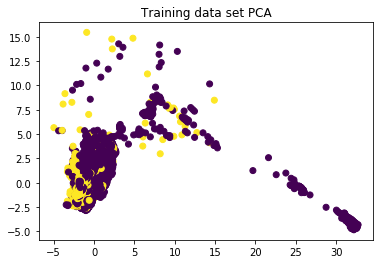

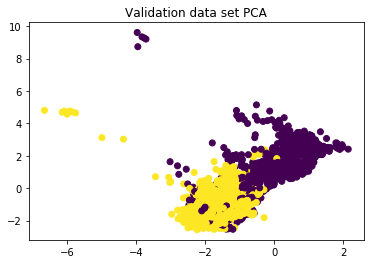

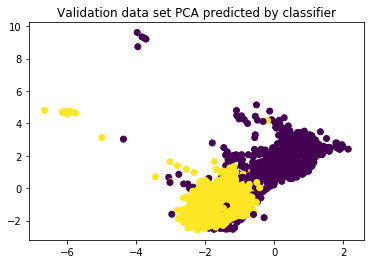

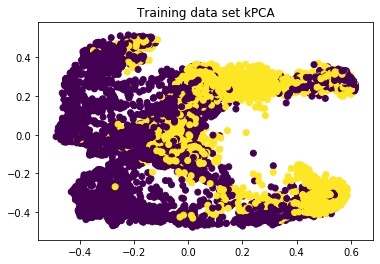

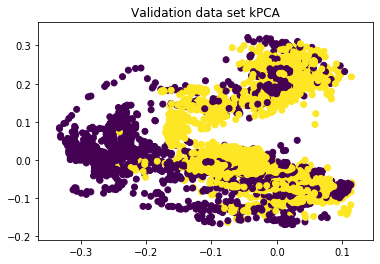

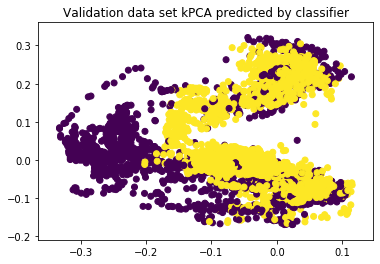

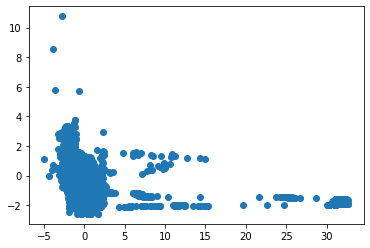

In [0]:
n_comps = 2
pca = PCA(n_components = n_comps)
X_train_pca = pca.fit_transform(X_train)
X_validate_pca = pca.transform(X_validate)
print(pca.explained_variance_ratio_)

kpca = KernelPCA(n_components = n_comps, kernel='rbf', gamma=0.1)
X_train_kPCA = kpca.fit_transform(X_train)
X_validate_kPCA = kpca.transform(X_validate)

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=failure)
ax.set_title('Training data set PCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=failure_val)
ax.set_title('Validation data set PCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_pca[:,0], X_validate_pca[:,1], c=y_predict)
ax.set_title('Validation data set PCA predicted by classifier')

fig, ax = plt.subplots()
ax.scatter(X_train_kPCA[:,0], X_train_kPCA[:,1], c=failure)
ax.set_title('Training data set kPCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_kPCA[:,0], X_validate_kPCA[:,1], c=failure_val)
ax.set_title('Validation data set kPCA')

fig, ax = plt.subplots()
ax.scatter(X_validate_kPCA[:,0], X_validate_kPCA[:,1], c=y_predict)
ax.set_title('Validation data set kPCA predicted by classifier')

fig, ax = plt.subplots()
ax.scatter(X_train_pca[:,0], impurity_train)



In [0]:



from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

class PFA(object):   #what does this do?
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [0]:
X_train_PFA = X_train[:,[18,36,2,37,14,8,9,21,25,28]]
X_validate_PFA = X_validate[:,[18,36,2,37,14,8,9,21,25,28]]

X_train_bad = X_train[:, [1,2,3,4,5,6,7,8,9,10]]
X_validate_bad = X_validate[:, [1,2,3,4,5,6,7,8,9,10]]

model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
model.fit(X_train_PFA, failure)

print('Testing Score: {}'.format(model.score(X_train_PFA, failure)))
print('Validation Score: {}'.format(model.score(X_validate_PFA, failure_val)))

model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
model.fit(X_train_bad, failure)

print('Testing Score: {}'.format(model.score(X_train_bad, failure)))
print('Validation Score: {}'.format(model.score(X_validate_bad, failure_val)))

Testing Score: 0.8060611576265017
Validation Score: 0.7356582388840454
Testing Score: 0.8174372042227885
Validation Score: 0.7933740191804708


In [0]:
from sklearn.feature_selection import SelectKBest, f_classif

k_kB = 10
kbest = SelectKBest(f_classif, k=k_kB)
X_new = kbest.fit_transform(X_train, failure)

print(X_new.shape)
print(kbest.get_support())

X_train_bad = X_train[:, ~kbest.get_support()] #all of the features that weren't selected
X_val_bad = X_validate[:, ~kbest.get_support()]

X_new_val = X_validate[:, kbest.get_support()]

model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
model.fit(X_new, failure)

print('Training Score: {}'.format(model.score(X_new, failure)))
print('Validation Score: {}'.format(model.score(X_new_val, failure_val)))

model = LogisticRegression(solver='lbfgs', max_iter=1000, C=100)
model.fit(X_train_bad, failure)

print('Testing Score: {}'.format(model.score(X_train_bad, failure)))
print('Validation Score: {}'.format(model.score(X_val_bad, failure_val)))

nums = np.linspace(0,40, num=41)
feats = nums[kbest.get_support()]
print(feats) #should show the index of the selected features



(10988, 10)
[False  True False False False  True  True False False False  True  True
  True  True False False False False False False False False False False
  True False False False False False False False False False False False
 False  True False False  True]
Training Score: 0.8082453585729887
Validation Score: 0.7611159546643418
Testing Score: 0.8244448489261011
Validation Score: 0.7785527462946817
[ 1.  5.  6. 10. 11. 12. 13. 24. 37. 40.]
